In [1]:
import torch
from easyGPR_helper import set_gpytorch_settings, GPRModel
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from easyGPR_helper import set_gpytorch_settings, GPRModel
from gpytorch.kernels import ScaleKernel, PolynomialKernel, PeriodicKernel, RBFKernel
from gpytorch.kernels import CosineKernel, MaternKernel, LinearKernel
from custom_kernels import GeneralizedCauchyKernel

import skimage.io as skio
import skimage.color as skcolor
import skimage.transform as sktrans
import skimage.filters as skfilter
import skimage.metrics as skmetrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Load Images (Must be Square)

In [2]:
LR_img = skio.imread("images/toucan_LR.png")
HR_img = skio.imread("images/toucan_HR.png")

LR_img = LR_img.astype(np.float32) / 255.0 # Normalize to 0-1 values
print("LR shape:", LR_img.shape)
print("HR shape:", HR_img.shape)

LR shape: (96, 96, 3)
HR shape: (288, 288, 3)


### Upsampling via Bicubic Interpolation

In [3]:
#Upsampling w/ Bicubic Interpolation
scale_factor = HR_img.shape[0] // LR_img.shape[0]
upsampled_img = sktrans.resize(LR_img, (LR_img.shape[0]*scale_factor, LR_img.shape[1]*scale_factor), order = 3, preserve_range=True)

### Gaussian Process Model

In [4]:
kernel = ScaleKernel(GeneralizedCauchyKernel())

#plan to make this a loop later when modularized

### Partition L into patches and train the model on it

In [5]:
height, width, color = LR_img.shape

#Split into 3x3 Grid
patch_rows, patch_cols = 3, 3
patch_height = int(height / patch_rows)
patch_width = int(width / patch_cols)
overlap = 3

#Store GP Models
models_R = [[None for _ in range(patch_cols)] for _ in range(patch_rows)]
models_G = [[None for _ in range(patch_cols)] for _ in range(patch_rows)]
models_B = [[None for _ in range(patch_cols)] for _ in range(patch_rows)]
models = [models_R, models_G, models_B]   # combine for easy indexing later

for i in range(patch_rows):
    for j in range(patch_cols):
        #define each patch dims
        row_start = int(max(0, i * patch_height - overlap))
        row_end = int(min(height, (i + 1) * patch_height + overlap))
        col_start = int(max(0, j * patch_width - overlap))
        col_end = int(min(width, (j + 1) * patch_width + overlap))

        for c, models_c in enumerate(models):
            patch = LR_img[row_start:row_end, col_start:col_end, c]
    
            x_list, y_list = [], []
            #3x3 Patch 
            for k in range(1, patch.shape[0] - 1):
                for l in range (1, patch.shape[1] - 1):
                    grid = patch[k-1:k+2, l-1:l+2]
                    grid_array = grid.flatten()
                    x_intensities = np.delete(grid_array, 4)
                    y_intensity = grid_array[4]
                    x_list.append(x_intensities)
                    y_list.append(y_intensity)
    
            x_train = np.array(x_list) #from L
            y_train = np.array(y_list).ravel() #from L
    
            #Train model
            model = GPRModel(train_x=x_train, train_y=y_train, kernel=kernel, scale_x=True)
            model.fit_model(training_iterations=10, lr=0.1, verbose = False)
            models_c[i][j] = model

### Apply previous model to each patch within the upsampled image to get H~.

In [6]:
#Partition Upsampled image for test data
height_UL, width_UL, _ = upsampled_img.shape

#Initialize
predicted_img_U = np.zeros_like(upsampled_img, dtype=np.float32) 

for c in range(3):
    predicted_img_U_ch = np.zeros((height_UL, width_UL), dtype=np.float32)
    patch_height_UL = int(height_UL / patch_rows)
    patch_width_UL = int(width_UL / patch_cols)
    
    for i in range(patch_rows):
        for j in range(patch_cols):
            row_start = int(max(0, i * patch_height_UL - overlap))
            row_end = int(min(height_UL, (i + 1) * patch_height_UL + overlap))
            col_start = int(max(0, j * patch_width_UL - overlap))
            col_end = int(min(width_UL, (j + 1) * patch_width_UL + overlap))
    
            patch = upsampled_img[row_start:row_end, col_start:col_end, c]
    
            x_list = []
            for k in range(1, patch.shape[0] - 1):
                for l in range(1, patch.shape[1] - 1):
                    grid = patch[k-1:k+2, l-1:l+2]
                    grid_array = grid.flatten()
                    x_intensities = np.delete(grid_array, 4)
                    x_list.append(x_intensities)
    
            x_test = np.array(x_list) #from H_b for H~
            
            model = models[c][i][j]
            pred = model.make_predictions(x_test, type='f', return_type='numpy') #gives H~
            y_pred = pred.mean.astype(np.float32)
            
            # y_pred = np.clip((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()), 0, 1)
            pred_patch = y_pred.reshape(patch.shape[0] - 2, patch.shape[1] - 2)

            predicted_img_U_ch[row_start+1:row_end-1, col_start+1:col_end-1] = pred_patch
    predicted_img_U[:, :, c] = predicted_img_U_ch

# plt.imshow(predicted_img_U)
# # predicted_img_uint8 = np.clip(predicted_img_U * 255, 0, 255).astype(np.uint8)
# # plt.imshow(predicted_img_uint8)
# plt.title("GPR Upsampled Image")
# plt.axis("off") 
# plt.show()

In [7]:
#Blur and Downsample
blurred_img = skfilter.gaussian(predicted_img_U, channel_axis=-1)
dsampled_img = sktrans.resize(blurred_img, (int(blurred_img.shape[0]*(1/3)), int(blurred_img.shape[1]*(1/3))), preserve_range=True, anti_aliasing=True)

### Partion L~ into patches and train models on it.

In [8]:
#Partition ~L image for training data
height, width, colors_L = dsampled_img.shape

#Split into 2x2 Grid

#Store GP Models
models_L_R = [[None for _ in range(patch_cols)] for _ in range(patch_rows)]
models_L_G = [[None for _ in range(patch_cols)] for _ in range(patch_rows)]
models_L_B = [[None for _ in range(patch_cols)] for _ in range(patch_rows)]
models_L = [models_L_R, models_L_G, models_L_B]   # combine for easy indexing later

for i in range(patch_rows):
    for j in range(patch_cols):
        #define each patch dims
        row_start = int(max(0, i * patch_height - overlap))
        row_end = int(min(height, (i + 1) * patch_height + overlap))
        col_start = int(max(0, j * patch_width - overlap))
        col_end = int(min(width, (j + 1) * patch_width + overlap))
        
        for c, models_Lc in enumerate(models_L):
            patch_L = dsampled_img[row_start:row_end, col_start:col_end, c]
    
            x_list_L, y_list_L = [], []
            #3x3 Patch 
            for k in range(1, patch_L.shape[0] - 1):
                for l in range (1, patch_L.shape[1] - 1):
                    grid_L = patch_L[k-1:k+2, l-1:l+2]
                    grid_array_L = grid_L.flatten()
                    x_intensities_L = np.delete(grid_array_L, 4)
                    y_intensity_L = grid_array_L[4]
                    x_list_L.append(x_intensities_L) 
                    y_list_L.append(y_intensity_L)
    
            x_train_L = np.array(x_list_L) #from L~
            y_train_L = np.array(y_list_L).ravel() #from L
    
            #Train model
            model_L = GPRModel(train_x=x_train_L, train_y=y_train_L, kernel=kernel, scale_x=True)
            model_L.fit_model(training_iterations=10, lr=0.1, verbose = False)
            models_Lc[i][j] = model_L

### Then apply this model to each patch within H~ to get super resolved H

In [9]:
# Stage 3: Deblurring / Final HR Reconstruction
height_H, width_H, _ = predicted_img_U.shape
predicted_img_H = np.zeros_like(predicted_img_U, dtype=np.float32)

patch_height_H = int(height_H / patch_rows)
patch_width_H  = int(width_H / patch_cols)

for c in range(3):
    predicted_img_H_ch = np.zeros((height_H, width_H), dtype=np.float32)
    for i in range(patch_rows):
        for j in range(patch_cols):
            row_start = int(max(0, i * patch_height_H - overlap))
            row_end = int(min(height_H, (i + 1) * patch_height_H + overlap))
            col_start = int(max(0, j * patch_width_H - overlap))
            col_end = int(min(width_H, (j + 1) * patch_width_H + overlap))

            patch_H = predicted_img_U[row_start:row_end, col_start:col_end, c]

            # Build 3×3 neighborhoods for H~
            x_list_H = []
            for k in range(1, patch_H.shape[0] - 1):
                for l in range(1, patch_H.shape[1] - 1):
                    grid_H = patch_H[k-1:k+2, l-1:l+2]
                    grid_array_H = grid_H.flatten()
                    x_intensities_H = np.delete(grid_array_H, 4)
                    x_list_H.append(x_intensities_H)

            x_H_test = np.array(x_list_H)

            model_Lc = models_L[c][i][j]
            pred_H = model_Lc.make_predictions(x_H_test, type='f', return_type='numpy')
            y_pred_H = pred_H.mean.astype(np.float32) 
            
            # y_pred_H = np.clip((y_pred_H - y_pred_H.min()) / (y_pred_H.max() - y_pred_H.min()), 0, 1)
            pred_patch_H = y_pred_H.reshape(patch_H.shape[0] - 2, patch_H.shape[1] - 2)
            predicted_img_H_ch[row_start+1:row_end-1, col_start+1:col_end-1] = pred_patch_H

    predicted_img_H[:, :, c] = predicted_img_H_ch

predicted_img_H_uint8 = np.clip(predicted_img_H * 255, 0, 255).astype(np.uint8)

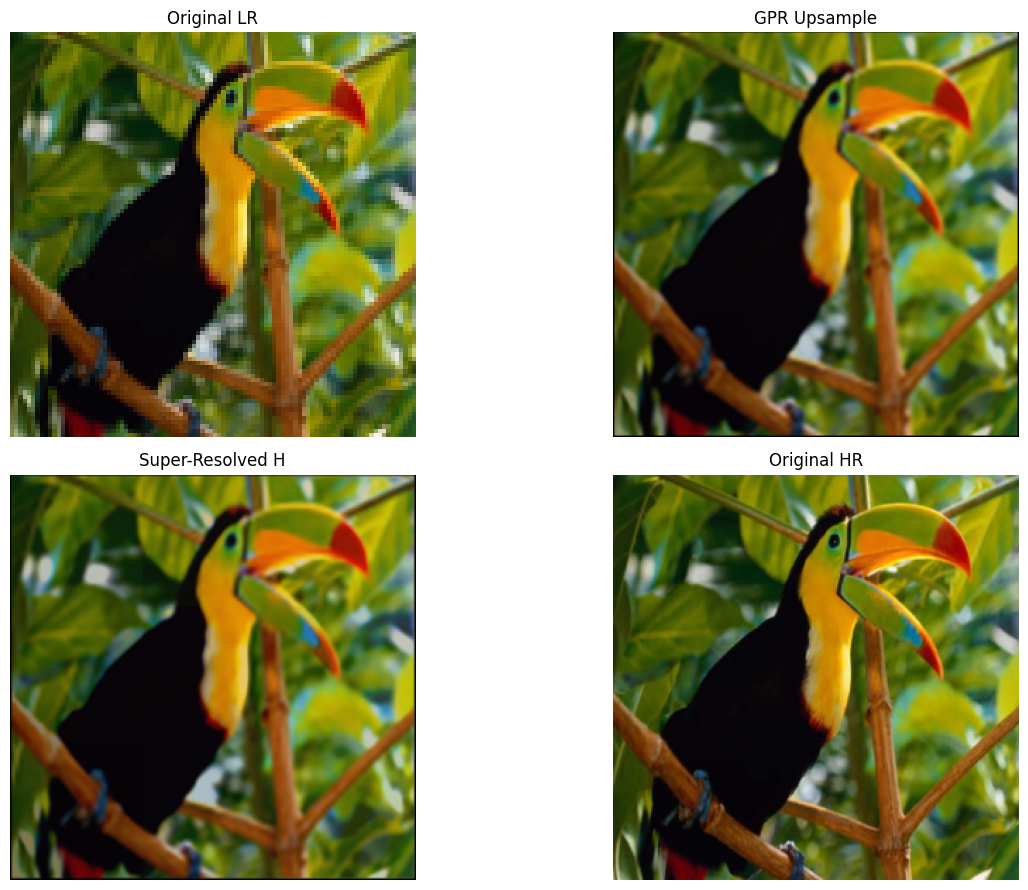

In [10]:
# Plotting

fig, ax = plt.subplots(2,2, figsize=(14, 9))
ax[0, 0].imshow(LR_img)
ax[0, 0].set_title("Original LR")
ax[0, 0].axis('off')

ax[0, 1].imshow(predicted_img_U)
ax[0, 1].set_title("GPR Upsample")
ax[0, 1].axis('off')

ax[1, 0].imshow(predicted_img_H_uint8) 
ax[1, 0].set_title("Super-Resolved H")
ax[1, 0].axis('off')

ax[1, 1].imshow(HR_img)
ax[1, 1].set_title("Original HR")
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Performance Metrics

In [11]:
def performance_metric(Truth_image, Predicted_image, label, data_range=255):
    psnr = skmetrics.peak_signal_noise_ratio(Truth_image, Predicted_image, data_range=255)
    ssim = skmetrics.structural_similarity(Truth_image, Predicted_image, channel_axis=-1, data_range=255)
    return {"Method/Kernel": label, "PSNR": psnr, "SSIM": ssim}

results = []
results.append(performance_metric(HR_img, upsampled_img, "Bicubic Interpolation"))
results.append(performance_metric(HR_img, predicted_img_H_uint8, "Generalized Cauchy"))

df = pd.DataFrame(results)
print(df)

           Method/Kernel       PSNR      SSIM
0  Bicubic Interpolation   9.122454  0.049438
1     Generalized Cauchy  24.941458  0.891590
